## Spam Email Detection

### Initialisation

#### Import Libraries

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import wordcloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rishabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Import Dataset

In [2]:
df = pd.read_csv('emails.csv')
df.columns = ['Content','Label']
df['Label'].replace(to_replace=[1,0],value=['Spam','Not Spam'],inplace=True)
df.sample(5)

,Content,Label
5569,Subject: re : possible summer internship with ...,Not Spam
2840,"Subject: my departure from enron dear all , ...",Not Spam
4364,Subject: ethylene margin collar simulation mod...,Not Spam
5674,Subject: re : enron weather research good aft...,Not Spam
541,Subject: returned mail : can ' t create output...,Spam


#### Value Counts


In [3]:
df.value_counts().sum()

5728

### Data Cleaning

#### Missing Value Analysis

In [4]:
df.isnull().sum()

Content    0
Label      0
dtype: int64

#### Duplicate Removal 

In [5]:
df.duplicated().sum()

33

In [6]:
df.drop_duplicates(inplace=True)
df.shape

(5695, 2)

#### Dataset Description

In [7]:
df.describe()

,Content,Label
count,5695,5695
unique,5695,2
top,Subject: naturally irresistible your corporate...,Not Spam
freq,1,4327


#### Shape

In [8]:
df.shape

(5695, 2)

### Exploratory Data Analysis

#### Label Distribution

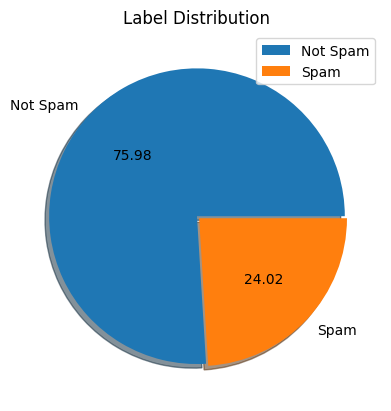

In [9]:
plt.pie(df['Label'].value_counts(),autopct="%0.2f",labels=['Not Spam','Spam'],explode=[0,0.02],shadow=True)
plt.legend(loc='best')
plt.title('Label Distribution')
plt.show()

#### Word Cloud 

##### Spam Mails

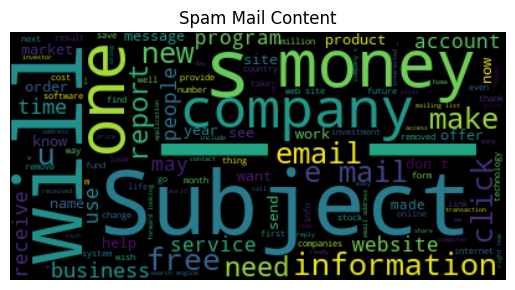

In [10]:
from wordcloud import WordCloud
text = " ".join(x for x in df[df['Label']=='Spam']['Content'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Spam Mail Content')
plt.show()

##### Not Spam Mails

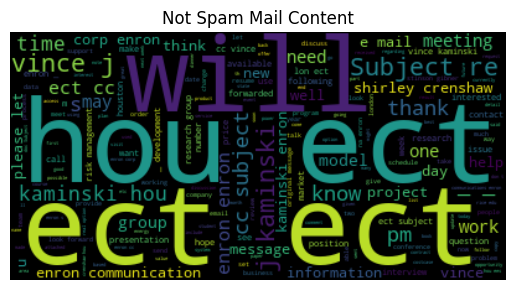

In [11]:
from wordcloud import WordCloud
text = " ".join(x for x in df[df['Label']=='Not Spam']['Content'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.title('Not Spam Mail Content')
plt.show()

#### Analyse Counts

In [12]:
df['Characters'] = [len(x) for x in df['Content']]
df['Words'] = [len(x.split(" ")) for x in df['Content']]
df[['Characters','Words']].describe()

,Characters,Words
count,5695.000000,5695.000000
mean,1558.067076,358.137313
std,2047.078711,452.047939
min,13.000000,3.000000
25%,508.500000,112.500000
50%,979.000000,232.000000
75%,1893.000000,439.000000
max,43952.000000,8984.000000


##### Character Distribution

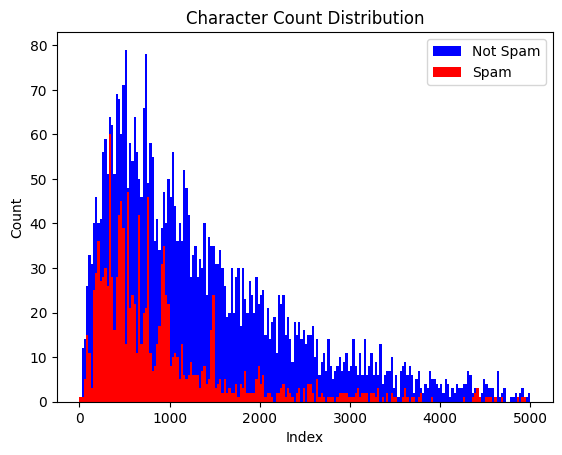

In [13]:
plt.hist(df[df['Label']=='Not Spam']['Characters'],bins=200,range=(0,5000),color='blue',label='Not Spam')
plt.hist(df[df['Label']=='Spam']['Characters'],bins=200,range=(0,5000),color='red',label='Spam')
plt.legend(loc="best")
plt.title("Character Count Distribution")
plt.xlabel('Index')
plt.ylabel('Count')
plt.show()

##### Word Distribution

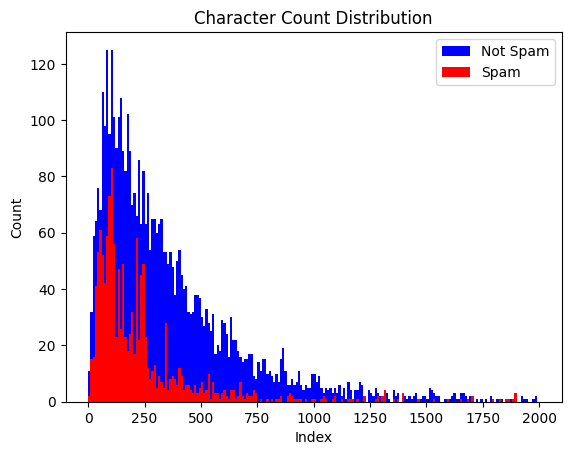

In [14]:
plt.hist(df[df['Label']=='Not Spam']['Words'],bins=200,range=(0,2000),color='blue',label='Not Spam')
plt.hist(df[df['Label']=='Spam']['Words'],bins=200,range=(0,2000),color='red',label='Spam')
plt.legend(loc="best")
plt.title("Character Count Distribution")
plt.xlabel('Index')
plt.ylabel('Count')
plt.show()

#### Pairplots

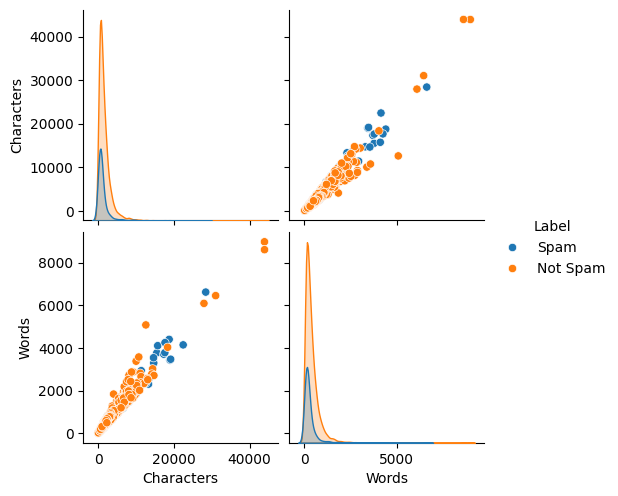

In [15]:
sb.pairplot(df,hue='Label')
plt.show()

#### Heatmap

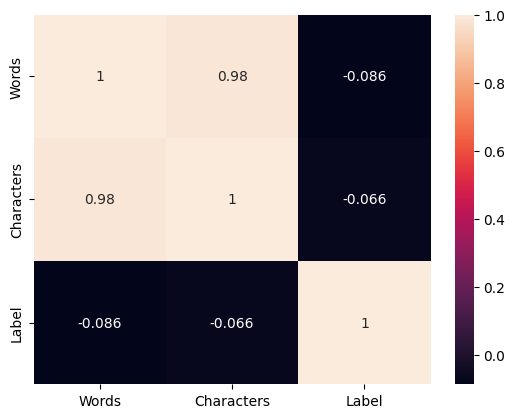

In [16]:
df.replace(to_replace=['Spam','Not Spam'],value=[1,0],inplace=True)
sb.heatmap(df[['Words','Characters','Label']].corr(),annot=True)
df.replace(to_replace=[1,0],value=['Spam','Not Spam'],inplace=True)

### Text Preprocessing

#### Remove Subject and Replied Notations

In [17]:
df['Content'] = [str.replace('subject: ','') for str in df['Content']]
df['Content'] = [str.replace('re : ','') for str in df['Content']]
df.sample(10)

,Content,Label,Characters,Words
4426,"Subject: program posted hello all , the prog...",Not Spam,491,121
4854,Subject: seeking opportunity in computational ...,Not Spam,3431,702
4089,"Subject: energycast dear vince , i hope your...",Not Spam,1047,226
1515,"Subject: lunch with it and credit tanya , ye...",Not Spam,1393,346
4663,Subject: thank you . i would like to take thi...,Not Spam,467,109
2605,Subject: rtp project thanks vince . i think t...,Not Spam,1485,388
5599,"Subject: thanks thanks for the update , vince...",Not Spam,1384,377
2277,"Subject: charm jim , charm looks more like a...",Not Spam,1887,469
2621,Subject: contact info i will be out next week...,Not Spam,272,60
4736,Subject: outage pricing model revision : allow...,Not Spam,793,156


#### Porter Stemming

In [31]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_sentence(sentence):
    new=""
    for word in sentence.split(" "):
        new+=stemmer.stem(word.strip(',').strip('!').strip(' '))+" "
    return new

df['Content'] = [stem_sentence(row) for row in df['Content']]

### Model Preparation

#### Test-Train Split

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(df['Content'],df['Label'],test_size=0.3)

#### Vectorization

In [ ]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### Model Fitting

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150)
model.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=150)

#### Prediction and Accuracy Test

In [ ]:
from sklearn.metrics import accuracy_score,f1_score,precision_score
Y_predict = model.predict(X_test)
print(f"Accuracy: {round(accuracy_score(Y_test,Y_predict)*100,3)}")
print(f"Precision: {round(precision_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")
print(f"F1 Score: {round(f1_score(Y_test,Y_predict,labels=['Spam','Not Spam'],pos_label='Not Spam')*100,3)}")

Accuracy: 97.835
Precision: 97.372
F1 Score: 98.553


#### Confusion Matrix

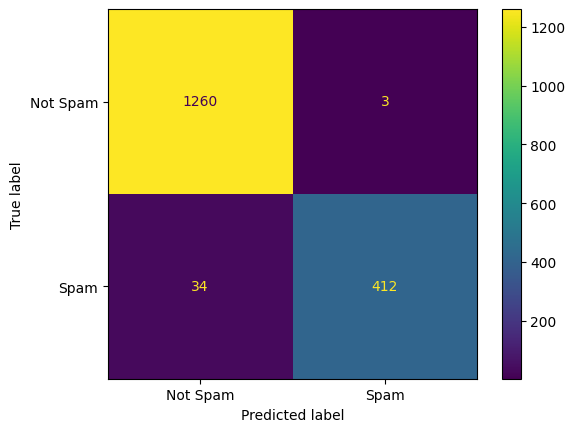

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(Y_test, Y_predict,labels=model.classes_)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = model.classes_)
cm_display.plot()
plt.show()

### Model Saving and Storing

#### Model Pickling

In [ ]:
import pickle
fm = open('pickles/model_pickle','wb')
pickle.dump(model,fm)

fv = open('pickles/vectorizer_pickle','wb')
pickle.dump(vectorizer,fv)